# DCGAN with cats dataset

## import nesessary modules 

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from torch.utils.tensorboard import SummaryWriter
from modules.dcgan import Discriminator, Generator, initialize_weights

## set agnostic

In [21]:
# agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## load data set

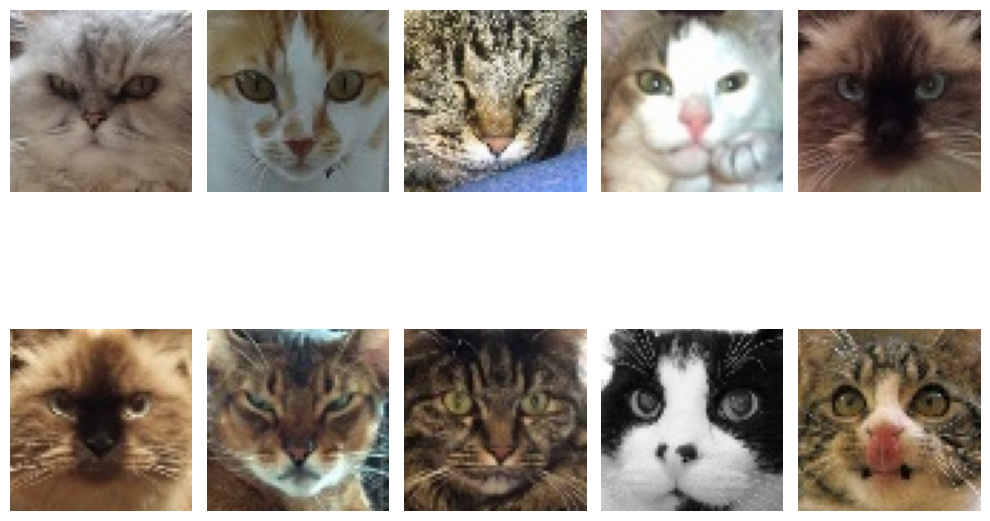

In [22]:

# Set the path to the dataset
dataset_path = 'dataset/cats/'

# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Set the number of images to plot
num_images = 10

# Create a new figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))

# Iterate over the first num_images filenames and plot the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    img = Image.open(img_path)

    # Convert the image to a numpy array
    img_arr = np.asarray(img)

    # Plot the image on the corresponding subplot
    row = i // 5
    col = i % 5
    axes[row, col].imshow(img_arr, cmap='gray')
    axes[row, col].axis('off')

# Adjust the spacing of the figure
fig.tight_layout()

# Show the figure
plt.show()


## load images to tensor and normalize images

In [23]:
# set image size
img_size = 64

# Set the path to the dataset
dataset_path = 'dataset/cats/'

# Set the number of images to transform
NUM_IMAGES = 15747

In [24]:
# Get the list of image filenames
image_filenames = os.listdir(dataset_path)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:NUM_IMAGES]):
    # Load the image
    img_path = os.path.join(dataset_path, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([15747, 3, 64, 64])


## separate batch size 

In [25]:
# set batch size
batch_size = 16

data_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True, drop_last=True)

data_iter = iter(data_loader)
print(next(data_iter).shape)

torch.Size([16, 3, 64, 64])


## import the model

In [26]:
from modules.dcgan import Discriminator, Generator, initialize_weights

## Set hyperparameter before training iteration

In [27]:
# base on the paper
LEARNING_RATE = 1e-4  #0.0001
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 3
LATENT_DIM = 100

NUM_EPOCHS = 200

FEATURES_DISC = 64
FEATURES_GEN = 64

## Train model and save weight and log 

### define save weight function

In [28]:
def save_weight(model, epoch, out_path="weights/cats/DCGAN",prefix=""):
    """Save weight to xxx.pt file"""
    os.makedirs(out_path, exist_ok=True)
    torch.save(model.state_dict(), f'{out_path}{prefix}{epoch}.pt')

### define gen_log function

In [29]:
import subprocess

def gen_log(log_path, message):
    command = ["python", "./modules/gen_log.py", "--log_file", log_path, "--message", message]

    subprocess.run(command, check=True)

## initialize weigths

In [30]:
gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# init weight
initialize_weights(gen)
initialize_weights(disc)

## training process
parameter base on DCGAN paper https://arxiv.org/abs/1511.06434
except learning rate

In [32]:
import time
import numpy as np

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, LATENT_DIM, 1, 1).to(device)

writer = SummaryWriter(f'logs/cats/DCGAN')

# writer_real = SummaryWriter(f"logs/real")
# writer_fake = SummaryWriter(f"logs/fake")
# writer_time = SummaryWriter("logs/time")
step = 0

gen.train()
disc.train()

time_use = 0

for epoch in range(NUM_EPOCHS):

    # Shuffle the dataset at the beginning of each epoch
    data_loader = DataLoader(transformed_images, batch_size=batch_size, shuffle=True, drop_last=True)

    lossG = 0
    lossD = 0

    # use time for time measurement
    start_time = time.time()
    
    for batch_idx, real in enumerate(data_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # append loss to list
        lossG += loss_gen
        lossD += loss_disc

        # # Print losses occasionally and print to tensorboard
        if batch_idx % BATCH_SIZE == 0:
            step += 1

        if epoch == 0 and batch_idx == 0:
            meanG_loss = lossG / BATCH_SIZE
            meanD_loss = lossD / BATCH_SIZE

            writer.add_scalar('Loss/loss_disc', lossD, epoch)
            writer.add_scalar('Loss/loss_gen', lossG, epoch)
            writer.add_scalar("traing time", time_use, epoch)


    end_time = time.time()
    epoch_time = end_time - start_time

    time_use += epoch_time 

    epoch_index = epoch+1

    # calculate mean value
    meanG_loss = lossG / len(data_loader.dataset)
    meanD_loss = lossD / len(data_loader.dataset)

    message = f'''Epoch: {epoch_index}, Using Time: {epoch_time:.4f}, Loss D: {meanD_loss:.4f}, Loss G: {meanG_loss:.4f}'''

    # generate log
    gen_log("./logs/cats/DCGAN.log", message)

    # save weight of models
    save_weight(gen, epoch+1, out_path="weights/DCGAN/cats/", prefix="G")
    save_weight(disc, epoch+1, out_path="weights/DCGAN/cats/", prefix="D")

    print(
        f"Epoch [{epoch_index}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(data_loader)} Using Time: {epoch_time:.4f}\
            Loss D: {meanD_loss:.4f}, loss G: {meanG_loss:.4f}"
    )

    # tensorboard
    writer.add_scalar('Loss/loss_disc', meanD_loss, epoch_index)
    writer.add_scalar('Loss/loss_gen', meanG_loss, epoch_index)
    writer.add_scalar("traing time", time_use, epoch_index)

    with torch.no_grad():
        fake = gen(fixed_noise)
        # take out (up to) 32 examples
        img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

        writer.add_image("All/Real", img_grid_real, global_step=epoch_index)
        writer.add_image("All/Fake", img_grid_fake, global_step=epoch_index)


Log file directory would be created at: ./logs/cats
create log file
Epoch [1/200] Batch 984/984 Using Time: 130.1861            Loss D: 0.0240, loss G: 0.1388
Epoch [2/200] Batch 984/984 Using Time: 131.5488            Loss D: 0.0323, loss G: 0.1123
Epoch [3/200] Batch 984/984 Using Time: 132.4545            Loss D: 0.0331, loss G: 0.1147
Epoch [4/200] Batch 984/984 Using Time: 133.0405            Loss D: 0.0307, loss G: 0.1305
Epoch [5/200] Batch 984/984 Using Time: 135.6486            Loss D: 0.0276, loss G: 0.1470
Epoch [6/200] Batch 984/984 Using Time: 134.4690            Loss D: 0.0246, loss G: 0.1649
Epoch [7/200] Batch 984/984 Using Time: 134.8909            Loss D: 0.0219, loss G: 0.1783
Epoch [8/200] Batch 984/984 Using Time: 135.0350            Loss D: 0.0180, loss G: 0.2035
Epoch [9/200] Batch 984/984 Using Time: 135.9906            Loss D: 0.0165, loss G: 0.2181
Epoch [10/200] Batch 984/984 Using Time: 136.7353            Loss D: 0.0144, loss G: 0.2291
Epoch [11/200] Batch 

# Measure FID

use this implementation: https://github.com/mseitzer/pytorch-fid/tree/master

You need to import model first  
and masure define gen_log function

## define FID measurement function 

In [37]:
import subprocess
import torch
from torchvision.utils import save_image
import re

# Create a function to run the FID script
def run_fid(real_path, gen_path, epoch):
    command = ["python", "-m", "pytorch_fid", real_path, gen_path]

    output = subprocess.run(command, capture_output=True, text=True)

    # Extract the FID score using regular expressions
    output = output.stdout
    fid_score_match = re.search(r"FID:\s+(\d+\.\d+)", output)
    
    if fid_score_match:
        fid_score = float(fid_score_match.group(1))
        print("FID score:", fid_score)

        # Write the FID score to the log file
        gen_log(log_path="logs/cats/fid/DCGAN.log", message=f"Epoch: {epoch}, FID score: {fid_score}")
        
    else:
        print("FID score not found in the output.")

    return fid_score

def FID_measure(model, sample_size=100*8, batch_size=8, device="cpu", real_path="dataset/cats/", gen_path="generated_images", epoch=int):
    # Set the model to evaluation mode
    model.eval()

    # Create a folder for generated images if it doesn't exist
    os.makedirs(gen_path, exist_ok=True)
    torch.manual_seed(2023)

    # Generate images
    with torch.no_grad():
        for i in range(0, sample_size, batch_size):
            
            # Random value from the normal distribution
            z = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)

            # Random from uniform distribution in range [-2, 2]
            # z = torch.FloatTensor(batch_size, LATENT_DIM, 1, 1).uniform_(-2, 2).to(device)

            # Generate images
            gen_imgs = model(z)

            # Save images
            for j in range(batch_size):
                save_image(gen_imgs[j], f"{gen_path}/{i+j}.png", normalize=True)
        
    # Measure FID score between the real and generated images
    fid_score = run_fid(real_path, gen_path, epoch)
    return fid_score


## Load weight of model to measure FID score

In [38]:
def load_weight( generator, discriminator=None, weight_path="", index=int):

    # Load the saved weights
    generator.load_state_dict(torch.load(f'{weight_path}/G{index}.pt'))
    # discriminator.load_state_dict(torch.load(f'{weight_path}/D{index}.pt'))
    

In [39]:
import glob
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'logs/cats/DCGAN/')

# Specify the directory path
directory_path = Path('weights/cats/DCGAN/')

# Get the list of files ending with ".pth"
# file_list = list(directory_path.glob('*.pt'))


gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
# disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

sample_size = 10000

for i in range(NUM_EPOCHS):
    index_weight = i+1

    load_weight(generator=gen, weight_path=directory_path, index=index_weight)

    print('Epoch: ',index_weight)
    fid_score = FID_measure(gen, sample_size, batch_size=16, device=f"{device}", gen_path=f"gen_image/cats/DCGAN/{index_weight}/", epoch=index_weight)   
    
    writer.add_scalar("Metrics/FID Score", fid_score, index_weight)


FID score: 245.91032365307828
Log file directory would be created at: logs/cat/fid
create log file
FID score: 223.05403078827976
FID score: 178.26009262827256
FID score: 132.58698285748156
FID score: 174.97528720168063
FID score: 120.7014970346971
FID score: 150.9303989864902
FID score: 201.90927419400106
FID score: 94.77549060890235
FID score: 70.65895871590297
FID score: 54.75514768735222
FID score: 69.79991727492694
FID score: 78.55118644618744
FID score: 60.34220562478731
FID score: 51.30031454825624
FID score: 71.98084814270766
FID score: 50.93187247675874
FID score: 114.27162775120246
FID score: 78.72792786106686
FID score: 77.43238041780378
FID score: 108.42119229409352
FID score: 114.90779186321485
FID score: 74.67939393478227
FID score: 98.29572671026955
FID score: 66.21878661163333
FID score: 105.5998820950748
FID score: 69.27025681170602
FID score: 51.892083468037114
FID score: 67.07967730884232
FID score: 108.41329884881726
FID score: 89.93102033305817
FID score: 53.4572089

# Plot Graph from logs file

## Generator and Discriminatot loss

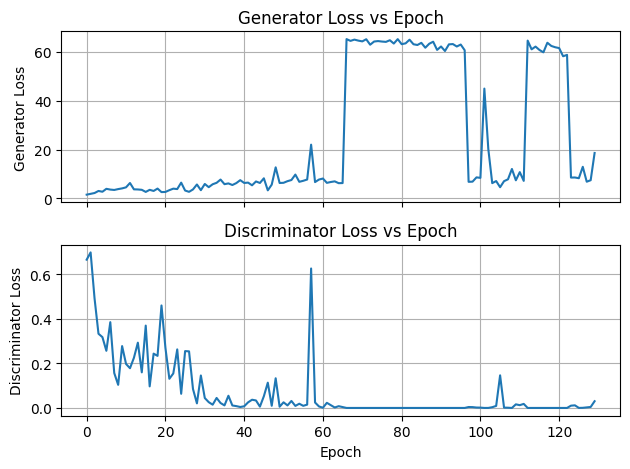

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import re

# Lists to store epoch and FID score values
gen_log = []
disc_log = []

# Read the log file
with open('logs/cats/DCGAN.log', 'r') as file:
    # Iterate over each line
    for line in file:
        # Extract epoch and FID score values from the line
        gen_match = re.search(r"Loss G: (\d+\.?\d*)", line)
        disc_match = re.search(r"Loss D: (\d+\.?\d*)", line)

        if gen_match is not None and disc_match is not None:
            gen = float(gen_match.group(1))
            disc = float(disc_match.group(1))

            # Append values to the lists
            gen_log.append(gen)
            disc_log.append(disc)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# Plot generator loss
ax1.plot(range(0, len(gen_log)), gen_log)
ax1.set_ylabel('Generator Loss')

# Plot discriminator loss
ax2.plot(range(0, len(disc_log)), disc_log)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Discriminator Loss')

# Add titles and grid
ax1.set_title('Generator Loss vs Epoch')
ax2.set_title('Discriminator Loss vs Epoch')
ax1.grid(True)
ax2.grid(True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## FID score compare to epoch 

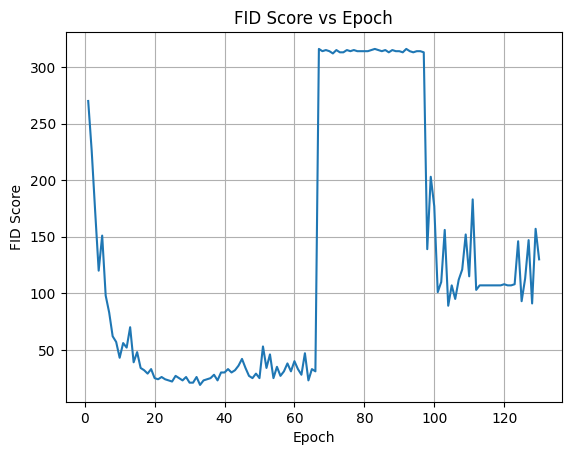

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

# Lists to store epoch and FID score values
epochs = []
fid_scores = []

# Read the log file
with open('logs/fid/DCGAN.log', 'r') as file:
    # Iterate over each line
    for line in file:
        # Extract epoch and FID score values from the line
        epoch_match = re.search(r"Epoch: (\d+)", line)
        fid_match = re.search(r"FID score: (\d+)", line)

        epoch = int(epoch_match.group(1))
        fid_score = float(fid_match.group(1))

        # Append values to the lists
        epochs.append(epoch)
        fid_scores.append(fid_score)

# Plot the graph
plt.plot(epochs, fid_scores)
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score vs Epoch')
plt.grid(True)
plt.show()


## FID score compare to using time

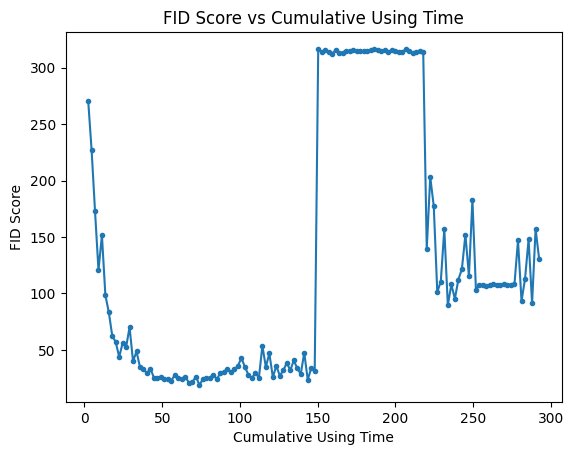

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
import re

using_time = []
fid_scores = []

# Read the log file
with open('logs/fid/DCGAN.log', 'r') as file:
    # Iterate over each line
    for line in file:
        # Extract FID score value from the line
        fid_match = re.search(r"FID score: (\d+\.?\d*)", line)
        fid_score = float(fid_match.group(1))

        # Append FID score to the list
        fid_scores.append(fid_score)

with open('logs/cats/DCGAN.log', 'r') as file:
    # Iterate over each line
    for line in file:
        # Extract using time value from the line
        time_match = re.search(r"Using Time: (\d+\.?\d*)", line)
        time_use = float(time_match.group(1)) 

        convert_time = time_use / 60

        # Append cumulative using time to the list
        if using_time:
            using_time.append(convert_time + using_time[-1])
        else:
            using_time.append(convert_time)

# Plotting the data
plt.plot(using_time, fid_scores, marker='.')
plt.xlabel('Cumulative Using Time')
plt.ylabel('FID Score')
plt.title('FID Score vs Cumulative Using Time')
plt.show()